In [1]:
import numpy as np
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

from utils import *

# 1. Load data

In [2]:
batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

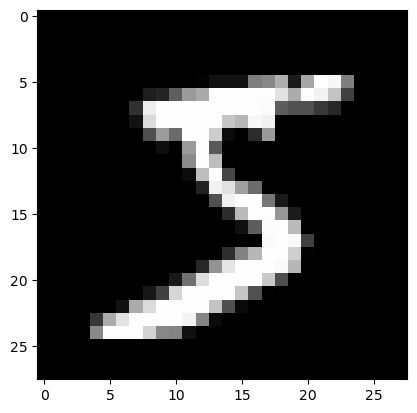

In [3]:
img, label = dataset[0]
plt.imshow(img[0], cmap='gray')

In [4]:
img[0].min(),img[0].max()

(tensor(-1.), tensor(1.))

# 2. Model

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
d_hidden = 30

class Autoencoder(nn.Module):
    def __init__(self, d=d_hidden):
        super().__init__()
        self.d = d
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, self.d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        hidden = self.encoder(x)
        x = self.decoder(hidden)
        return hidden, x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()

# 3. Training

In [6]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

num_epochs = 20
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1) # [batch_size, 28*28]

        # forward
        hidden,output = model(img)
        loss = criterion(output, img)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    # display_images(None, output)
torch.save(model, './results/AE.pth')

epoch [1/20], loss:0.2012
epoch [2/20], loss:0.1483
epoch [3/20], loss:0.1203
epoch [4/20], loss:0.1047
epoch [5/20], loss:0.0959
epoch [6/20], loss:0.0959
epoch [7/20], loss:0.0885
epoch [8/20], loss:0.0824
epoch [9/20], loss:0.0737
epoch [10/20], loss:0.0762


KeyboardInterrupt: 

# 4. Visualize the hidden vectors

In [7]:
model = torch.load('./results/AE.pth')
with torch.no_grad():
    hidden_vectors = []
    labels = []
    for data in dataloader:
        img, lable = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        hidden,output = model(img)
        hidden_vectors.append(hidden)
        labels.append(lable)

In [8]:
hidden_vectors = torch.cat(hidden_vectors, dim=0).numpy()
labels = torch.cat(labels, dim=0).numpy().reshape(-1, 1)
print(hidden_vectors.shape, labels.shape)

(60000, 30) (60000, 1)


In [9]:
from sklearn.manifold import TSNE
embedded_vectors = TSNE(n_components=2).fit_transform(hidden_vectors[:1000,:])
print(embedded_vectors.shape)

(1000, 2)


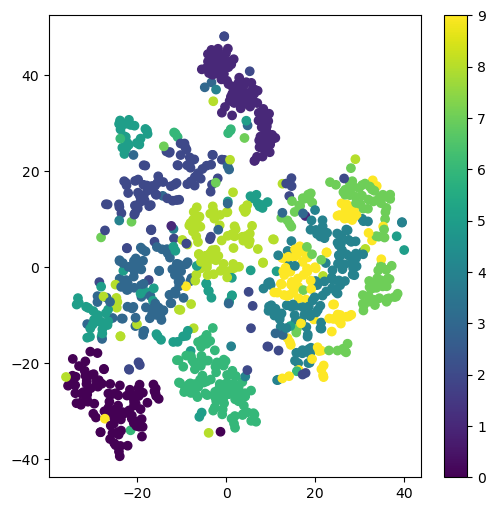

In [10]:
plt.figure(figsize=(6, 6))
plt.scatter(embedded_vectors[:, 0], embedded_vectors[:, 1], c=labels[:1000,:],cmap='viridis')
plt.colorbar()
plt.show()